In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
from lmfit import Model

# Multiresponse parameter estimation

The aim of this example (Bates and Watts, 1988, p. 147) is to present how a multiresponse parameter estimation can be performed properly. 

Note that specific adjustments such as:

    i) using different optimization algorithms/methods (lmfit, scipy's L-BFGS-B & Differential Evolution)

    ii) reducing the number of responses

    iii) using different loss functions for convergence

    iv) re-assessing initial values for parameter estimation

might be needed before/after assessing the models in order to attain optimal results.

In [2]:
# create the initial dataframe
df = pd.DataFrame(columns = ["Time (min)", "a-Pinene (%)", "Dipentene (%)", "Allocimene (%)", "Dimer (%)"])

time = np.array([1230, 3060, 4920, 7800, 10680, 15030, 22620, 36420])
df["Time (min)"] = time

a_pinene = np.array([88.35, 76.4, 65.1, 50.4, 37.5, 25.9, 14.0, 4.5])
df['a-Pinene (%)'] = a_pinene

depentene = np.array([7.3, 15.6, 23.1, 32.9, 42.7, 49.1, 57.4, 63.1])
df["Dipentene (%)"] = depentene

allocimene = np.array([2.3, 4.5, 5.3, 6.0, 6.0, 5.9, 5.1, 3.8])
df["Allocimene (%)"] = allocimene

pyronene = np.array([0.4, 0.7, 1.1, 1.5, 1.9, 2.2, 2.6, 2.9])
df["Pyronene (%)"] = pyronene

dimer = np.array([1.75, 2.8, 5.8, 9.3, 12.0, 17.0, 21.0, 25.7])
df['Dimer (%)'] = dimer

In [3]:
df

,Time (min),a-Pinene (%),Dipentene (%),Allocimene (%),Dimer (%),Pyronene (%)
0,1230,88.35,7.3,2.3,1.75,0.4
1,3060,76.40,15.6,4.5,2.80,0.7
2,4920,65.10,23.1,5.3,5.80,1.1
3,7800,50.40,32.9,6.0,9.30,1.5
4,10680,37.50,42.7,6.0,12.00,1.9
5,15030,25.90,49.1,5.9,17.00,2.2
6,22620,14.00,57.4,5.1,21.00,2.6
7,36420,4.50,63.1,3.8,25.70,2.9


In [4]:
corr = df.corr()
corr.style.background_gradient(cmap='coolwarm')

,Time (min),a-Pinene (%),Dipentene (%),Allocimene (%),Dimer (%),Pyronene (%)
Time (min),1.000000,-0.916468,0.910017,0.011023,0.963497,0.921403
a-Pinene (%),-0.916468,1.000000,-0.999699,-0.367905,-0.985233,-0.999580
Dipentene (%),0.910017,-0.999699,1.000000,0.380490,0.981690,0.999257
Allocimene (%),0.011023,-0.367905,0.380490,1.000000,0.210458,0.355696
Dimer (%),0.963497,-0.985233,0.981690,0.210458,1.000000,0.986759
Pyronene (%),0.921403,-0.999580,0.999257,0.355696,0.986759,1.000000


Here you can find random graphical illustrations of the correlations between the variables with the ones being close to unity indicating a linear relationship

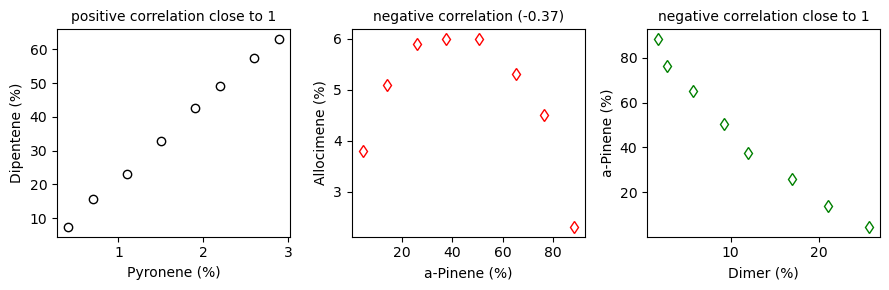

In [5]:
fig, ax = plt.subplots(ncols = 3, figsize = (9,3))

ax[0].plot(df['Pyronene (%)'], df['Dipentene (%)'],'ko', mfc = 'none')
ax[0].set_title('positive correlation close to 1', fontsize = 10)
ax[0].set_xlabel('Pyronene (%)')
ax[0].set_ylabel('Dipentene (%)')

ax[1].plot(df['a-Pinene (%)'], df['Allocimene (%)'],'rd', mfc = 'none')
ax[1].set_title('negative correlation (-0.37)', fontsize = 10)
ax[1].set_xlabel('a-Pinene (%)')
ax[1].set_ylabel('Allocimene (%)')

ax[2].plot(df['Dimer (%)'], df['a-Pinene (%)'],'gd', mfc = 'none')
ax[2].set_title('negative correlation close to 1', fontsize = 10)
ax[2].set_xlabel('Dimer (%)')
ax[2].set_ylabel('a-Pinene (%)')

fig.tight_layout()

In [6]:
# original matrix with 5 responses
y_5_responses = df.iloc[:, 1:].T.values
y_5_responses

array([[88.35, 76.4 , 65.1 , 50.4 , 37.5 , 25.9 , 14.  ,  4.5 ],
       [ 7.3 , 15.6 , 23.1 , 32.9 , 42.7 , 49.1 , 57.4 , 63.1 ],
       [ 2.3 ,  4.5 ,  5.3 ,  6.  ,  6.  ,  5.9 ,  5.1 ,  3.8 ],
       [ 1.75,  2.8 ,  5.8 ,  9.3 , 12.  , 17.  , 21.  , 25.7 ],
       [ 0.4 ,  0.7 ,  1.1 ,  1.5 ,  1.9 ,  2.2 ,  2.6 ,  2.9 ]])

In [7]:
# reduced matrix with 4 responses
y_4_responses = df.iloc[:, 1:-1].T.values
y_4_responses

array([[88.35, 76.4 , 65.1 , 50.4 , 37.5 , 25.9 , 14.  ,  4.5 ],
       [ 7.3 , 15.6 , 23.1 , 32.9 , 42.7 , 49.1 , 57.4 , 63.1 ],
       [ 2.3 ,  4.5 ,  5.3 ,  6.  ,  6.  ,  5.9 ,  5.1 ,  3.8 ],
       [ 1.75,  2.8 ,  5.8 ,  9.3 , 12.  , 17.  , 21.  , 25.7 ]])

In [8]:
# initial values for the ode_system
y_ode_init = df.iloc[0, 1:].values
y_ode_init

array([88.35,  7.3 ,  2.3 ,  1.75,  0.4 ])

In [9]:
# matrix of independent variable
t_obs = np.array([df.iloc[:, 0].T])
t_obs

array([[ 1230,  3060,  4920,  7800, 10680, 15030, 22620, 36420]])

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C')

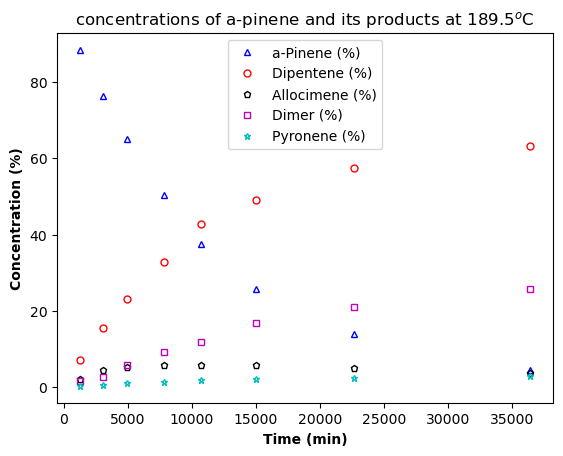

In [10]:
# plot the experimental values
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']

fig, ax = plt.subplots()

for idx, j in enumerate(df.columns[1:]):
    plt.plot(df['Time (min)'], df[j], marker = markers[idx], markersize = 5, 
             color = colors[idx], linestyle = " ", mfc = "none")
    plt.legend([col for col in df.columns[1:]])


ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C')

A linear kinetic model was proposed in Box et al. (1973) for the a-pinene data, of the form:

\begin{equation*} \frac{d γ_1}{dt} = -(θ_1 + θ_2)γ_1  \tag{1}\end{equation*}

\begin{equation*} \frac{d γ_2}{dt} = θ_1γ_1  \tag{2}\end{equation*}

\begin{equation*} \frac{d γ_3}{dt} = θ_2γ_1 - (θ_3 + θ_4)γ_3 + θ_5γ_5  \tag{3}\end{equation*}

\begin{equation*} \frac{d γ_4}{dt} = θ_3γ_3  \tag{4}\end{equation*}

\begin{equation*} \frac{d γ_5}{dt} = θ_4γ_3 - θ_5γ_5  \tag{5}\end{equation*}

In [11]:
# linear kinetic model structure
def ode_system(t, y, *p):
    
    dg1_dt = -(p[0] + p[1])*y[0]
    
    dg2_dt = p[0]*y[0]
    
    dg3_dt = p[1]*y[0] - (p[2] + p[3])*y[2] + p[4]*y[4]
    
    dg4_dt = p[2]*y[2]
    
    dg5_dt = p[3]*y[2] - p[4]*y[4]
    
    return np.hstack([dg1_dt, dg2_dt, dg3_dt, dg4_dt, dg5_dt])

# estimated rates at t = 1230 s
ode_system(1230, y_ode_init, 5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5)

array([-7.774800e-03,  5.247990e-03,  1.823791e-03,  1.041900e-05,
        6.926000e-04])

In [12]:
def regres_fun_original(t, a, b, c, d, e):
    
    sol_original = solve_ivp(ode_system, (t[0], t[-1]), y_ode_init, 
                    args = (a, b, c, d, e), t_eval = t)
    
    return sol_original.y

In [13]:
bnds = [(0, 1e-3), (0, 1e-3), (0, 1e-3), (0, 1e-3), (0, 1e-3)]

### 1st attempt with lmfit using 5 responses

**lmfit** is a high-level interface to non-linear optimization and curve fitting problems for Python. It builds on and extends many of the optimization methods of **scipy.optimize**. Initially inspired by (and named for) extending the Levenberg-Marquardt method from **scipy.optimize.leastsq**.

In [14]:
mod_original = Model(regres_fun_original)
params_original = mod_original.make_params(a=6.0e-5, b=3.0e-5, c=0.5e-5, d=30.0e-5, e=5.5e-5)

result_original = mod_original.fit(y_5_responses, params_original, t=time)

print(result_original.fit_report())

best_values_original_lmfit = np.array(list(result_original.best_values.values()))
best_fit_original_lmfit = result_original.best_fit

[[Model]]
    Model(regres_fun_original)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 43
    # data points      = 40
    # variables        = 5
    chi-square         = 29.4831869
    reduced chi-square = 0.84237677
    Akaike info crit   = -2.20237157
    Bayesian info crit = 6.24202570
[[Variables]]
    a:  5.8886e-05 +/- 7.2299e-07 (1.23%) (init = 6e-05)
    b:  2.7837e-05 +/- 6.8522e-07 (2.46%) (init = 3e-05)
    c:  1.7446e-04 +/- 1.1518e-05 (6.60%) (init = 5e-06)
    d:  3.9778e-05 +/- 1.3932e-05 (35.02%) (init = 0.0003)
    e:  3.6523e-05 +/- 2.6954e-05 (73.80%) (init = 5.5e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, e) = 0.879
    C(c, d) = 0.223
    C(b, c) = -0.160
    C(b, d) = 0.156
    C(a, b) = 0.131


### 2nd attempt with L-BFGS-B using 5 responses

Limited-memory **BFGS** is an optimization algorithm in the family of quasi-Newton methods that approximates the Broyden–Fletcher–Goldfarb–Shanno algorithm (BFGS) using a limited amount of computer memory. It is a popular algorithm for parameter estimation in machine learning. The algorithm's target problem is to minimize $f(x)$ over unconstrained values of the real-vector $x$ where $f$ is a differentiable scalar function.

In [15]:
def min_fun_original(p, t, y):
    
    y_pred = regres_fun_original(t, *p)
    z = y_pred - y

    return np.linalg.det(z.dot(z.T))
 
# the initial values could be adopted either from the original Bates and Watts or from the lmfit fit_report()
initial_values = [5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5]

min_sol_original_BFGS = minimize(min_fun_original,
                            initial_values,
                            args=(t_obs[0], y_5_responses),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_original_BFGS

      fun: 0.03573012119089249
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ -122.65452614,   266.66182691,   -25.25776596,    34.13382142,
       20986.90648705])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 534
      nit: 45
     njev: 89
   status: 0
  success: True
        x: array([5.99046580e-05, 3.19140895e-05, 1.00000000e-03, 8.80835151e-05,
       0.00000000e+00])

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 5 responses')

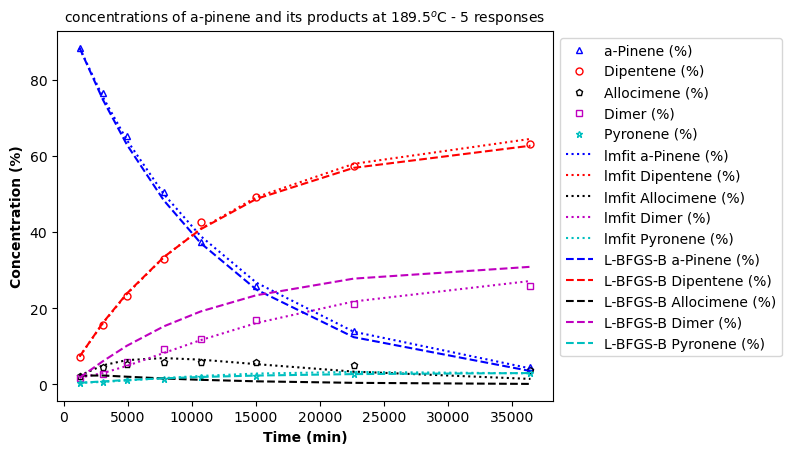

In [16]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:].values, 'L-BFGS-B ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(best_fit_original_lmfit):
    
    ax.plot(time, arr, ":", color = colors[idx])    

for idx, arr in enumerate(regres_fun_original(time, *min_sol_original_BFGS.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 5 responses', fontsize = 10)

## Assessing the original model with 5 responses using lmfit & L-BFGS-B

In [17]:
y_pred_original_lmfit = best_fit_original_lmfit
residuals_original_lmfit = y_pred_original_lmfit - df.iloc[:, 1:].T.values

y_pred_original_BFGS = regres_fun_original(time, *min_sol_original_BFGS.x)
residuals_original_BFGS = y_pred_original_BFGS - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - lmfit & L-BFGS-B (5 responses)')

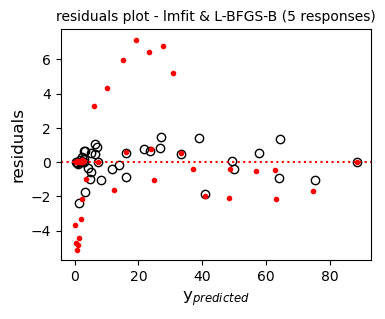

In [18]:
fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_pred_original_lmfit, residuals_original_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_original_BFGS, residuals_original_BFGS, 'r.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - lmfit & L-BFGS-B (5 responses)', fontsize = 10)

## Observations

**lmfit** seems to lead to a better convergence between the observed and predicted values most likely due to the stable **least-squares** approach. On the other hand, it can be assumed by examining the plots with concentration profiles and residuals that probably the convergence of the loss function **det(z.T.dot(z))** with multicollinearity on the response variables seems poor. 

That said, another approach for the loss function (i.e., **unweighted sum of squared residuals**) alongside a different scipy optimize method (i.e., **Differential Evolution**) are adopted to re-assess the fitting as demonstrated below. 

**Note that unweighted sum of squared residuals might be inadequate when response variables are in very different scales.**

### 3rd attempt with Differential Evolution (DE) using 5 responses

**Differential Evolution (DE)** is stochastic in nature (does not use gradient methods) to find the minimum, and can search large areas of candidate space, but often requires larger numbers of function evaluations than conventional gradient-based techniques.

In [19]:
# unweighted sum of squared residuals
def min_fun_lsq(p, t, y):
    
    y_pred = regres_fun_original(t, *p)
    z = y_pred - y

    return np.sum(z * z)

min_sol_original_DE = differential_evolution(
    min_fun_lsq,
    bnds,
    args=(t_obs[0], y_5_responses),
    strategy="rand1bin",
    mutation=(0.3, 1.0),
    recombination=0.7,
    popsize=50,
    maxiter=100
    )

min_sol_original_DE

     fun: 29.483898099990462
     jac: array([ 1732.47399644,  3329.4633635 ,  -859.70552597, -1073.48451834,
        -954.99869239])
 message: 'Optimization terminated successfully.'
    nfev: 21204
     nit: 83
 success: True
       x: array([5.88806537e-05, 2.78307795e-05, 1.74382247e-04, 3.94231855e-05,
       3.58732974e-05])

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 5 responses')

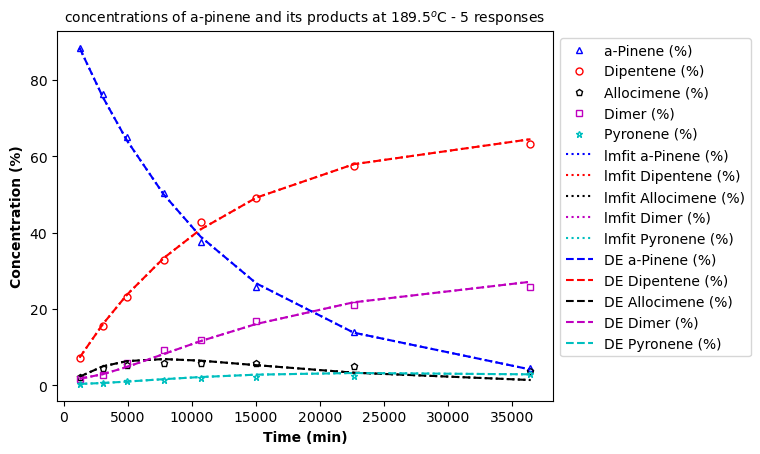

In [20]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:].values, 'DE ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(best_fit_original_lmfit):
    
    ax.plot(time, arr, ":", color = colors[idx])    

for idx, arr in enumerate(regres_fun_original(time, *min_sol_original_DE.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 5 responses', fontsize = 10)

## Assessing the original model with 5 responses using lmfit & DE

In [21]:
y_pred_original_lmfit = best_fit_original_lmfit
residuals_original_lmfit = y_pred_original_lmfit - df.iloc[:, 1:].T.values

y_pred_original_DE = regres_fun_original(time, *min_sol_original_DE.x)
residuals_original_DE = y_pred_original_DE - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - lmfit & DE (5 responses)')

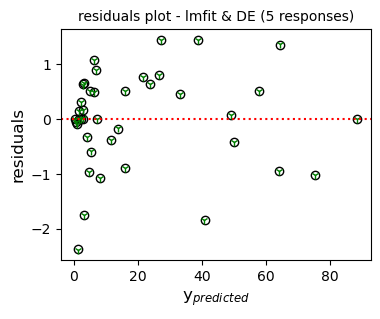

In [22]:
fig, ax = plt.subplots(figsize = (4,3))

ax.plot(y_pred_original_lmfit, residuals_original_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_original_DE, residuals_original_DE, 'g1')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - lmfit & DE (5 responses)', fontsize = 10)

## Observations

By studying the concentrations profile and residuals plots one can assume that **scipy (DE)** with **least_squared** loss function would lead to the same results as **lmfit** indicating that **both optimizers are equally powerful**.

### 1st attempt with lmfit using 4 responses (reduced)

In [23]:
def regres_fun_reduced(t, a, b, c, d, e):
    
    sol_reduced = solve_ivp(ode_system, (t[0], t[-1]), y_ode_init, 
                    args = (a, b, c, d, e), t_eval = t)
    
    return sol_reduced.y[:-1]

In [24]:
mod_reduced = Model(regres_fun_reduced)
params_reduced = mod_reduced.make_params(a=6.0e-5, b=3.0e-5, c=0.5e-5, d=30.0e-5, e=5.5e-5)

result_reduced = mod_reduced.fit(y_4_responses, params_reduced, t=time)

print(result_reduced.fit_report())

best_values_reduced_lmfit = np.array(list(result_reduced.best_values.values()))
best_fit_reduced_lmfit = result_reduced.best_fit

[[Model]]
    Model(regres_fun_reduced)
[[Fit Statistics]]
    # fitting method   = leastsq
    # function evals   = 49
    # data points      = 32
    # variables        = 5
    chi-square         = 26.4297014
    reduced chi-square = 0.97887783
    Akaike info crit   = 3.88008095
    Bayesian info crit = 11.2087605
[[Variables]]
    a:  5.8782e-05 +/- 7.8867e-07 (1.34%) (init = 6e-05)
    b:  2.8785e-05 +/- 9.4817e-07 (3.29%) (init = 3e-05)
    c:  1.7822e-04 +/- 1.3579e-05 (7.62%) (init = 5e-06)
    d:  6.7768e-05 +/- 3.0918e-05 (45.62%) (init = 0.0003)
    e:  4.8496e-05 +/- 3.8583e-05 (79.56%) (init = 5.5e-05)
[[Correlations]] (unreported correlations are < 0.100)
    C(d, e) = 0.832
    C(c, d) = 0.331
    C(b, d) = 0.330
    C(c, e) = 0.122


### 2nd attempt with L-BFGS-B using 4 responses (reduced)

In [25]:
def min_fun_reduced(p, t, y):
    
    y_pred = regres_fun_reduced(t, *p)
    z = y_pred - y

    return np.linalg.det(z.dot(z.T))

initial_values = [5.94e-5, 2.86e-5, 0.453e-5, 31.12e-5, 5.79e-5]

min_sol_reduced_BFGS = minimize(min_fun_reduced,
                            initial_values,
                            args=(t_obs[0], y_4_responses),
                            method="L-BFGS-B",
                            bounds = bnds)

min_sol_reduced_BFGS

      fun: 3.8725302012010716
 hess_inv: <5x5 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 14.35920569, -48.46728765,  -0.38848111,   8.53318252,
        -2.93182252])
  message: 'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 606
      nit: 63
     njev: 101
   status: 0
  success: True
        x: array([5.88477222e-05, 2.81236086e-05, 1.73598123e-04, 2.20394407e-05,
       1.84015784e-06])

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 4 responses')

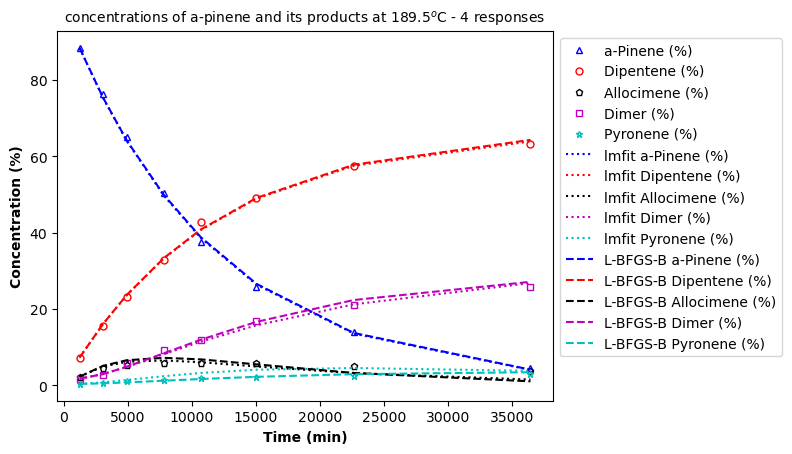

In [26]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['lmfit ' + df.columns[1:].values, 'L-BFGS-B ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(regres_fun_original(time, *best_values_reduced_lmfit)):
    
    ax.plot(time, arr, ":", color = colors[idx])
    
for idx, arr in enumerate(regres_fun_original(time, *min_sol_reduced_BFGS.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 4 responses', fontsize = 10)

## Assessing the original model with 4 responses using lmfit & L-BFGS-B 

In [27]:
y_pred_reduced_lmfit = regres_fun_original(time, *best_values_reduced_lmfit)
residuals_reduced_lmfit = y_pred_reduced_lmfit - df.iloc[:, 1:].T.values

y_pred_reduced_BFGS = regres_fun_original(time, *min_sol_reduced_BFGS.x)
residuals_reduced_BFGS = y_pred_reduced_BFGS - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residual plot - lmfit & BFGS (4 responses)')

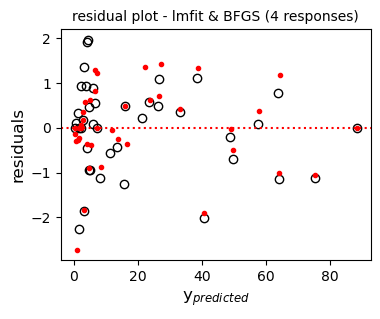

In [28]:
fig, ax = plt.subplots(figsize = (4,3))
ax.plot(y_pred_reduced_lmfit, residuals_reduced_lmfit, 'ko', mfc = 'none')
ax.plot(y_pred_reduced_BFGS, residuals_reduced_BFGS, 'r.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residual plot - lmfit & BFGS (4 responses)', fontsize = 10)

## Observations

Firstly it seems that **lmfit** optimizer performs slightly better using 5 responses instead of 4 responses as quantified by the lower values of Akaike info crit (i.e., -2.2 at 5 responses) in comparison to that of 4 responses (i.e., 3.9). 

On the other hand, the loss function **det(z.T.dot(z))** with multicollinearity on the response variables performs great when 4 responses (reduced) are used using **scipy (L-BFGS-B)**.

**Note that if the dependency can be explained (e.g., mass balance, or a response that has been imputed from other measured responses) and the offending responses identified, they should be removed and a multi responce analysis performed on the reduced data set**.

### 3rd attempt with Differential Evolution (DE) using 4 responses

In [29]:
# unweighted sum of squared residuals
def min_fun_lsq(p, t, y):
    
    y_pred = regres_fun_reduced(t, *p)
    z = y_pred - y

    return np.sum(z * z)

min_sol_reduced_DE = differential_evolution(
    min_fun_lsq,
    bnds,
    args=(t_obs[0], y_4_responses),
    strategy="rand1bin",
    mutation=(0.3, 1.0),
    recombination=0.7,
    popsize=50,
    maxiter=100
    )

min_sol_reduced_DE

     fun: 26.46382367936694
 message: 'Optimization terminated successfully.'
    nfev: 22598
     nit: 88
 success: True
       x: array([5.86930030e-05, 2.87393852e-05, 1.79294390e-04, 7.03370928e-05,
       4.99605365e-05])

Text(0.5, 1.0, 'concentrations of a-pinene and its products at 189.5$^o$C - 4 responses')

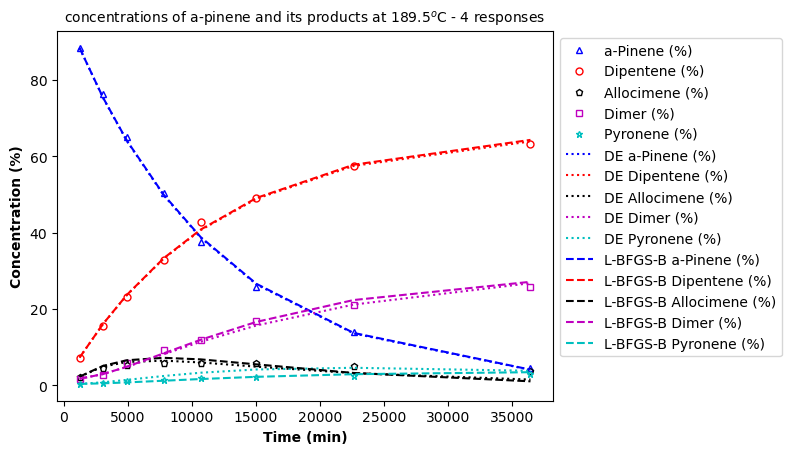

In [30]:
markers = ['^', 'o', 'p', 's', '*']
colors = ['b', 'r', 'k', 'm', 'c']
names = np.append(df.columns[1:].values, ['DE ' + df.columns[1:].values, 'L-BFGS-B ' + df.columns[1:].values])

fig, ax = plt.subplots()

for idx, arr in enumerate(df.columns[1:]):
    ax.plot(df["Time (min)"], df[arr], color = colors[idx],
            marker = markers[idx], markersize = 5, linestyle = " ", mfc = "none")
    
for idx, arr in enumerate(regres_fun_original(time, *min_sol_reduced_DE.x)):
    
    ax.plot(time, arr, ":", color = colors[idx])
    
for idx, arr in enumerate(regres_fun_original(time, *min_sol_reduced_BFGS.x)):
    
    ax.plot(time, arr, "--", color = colors[idx])

ax.legend([col for col in names], bbox_to_anchor=(1.0, 1.0))    
ax.set_xlabel("Time (min)", fontweight = "bold")
ax.set_ylabel("Concentration (%)", fontweight='bold')
ax.set_title('concentrations of a-pinene and its products at 189.5$^o$C - 4 responses', fontsize = 10)

In [31]:
y_pred_reduced_DE = regres_fun_original(time, *min_sol_reduced_DE.x)
residuals_reduced_DE = y_pred_reduced_DE - df.iloc[:, 1:].T.values

y_pred_reduced_BFGS = regres_fun_original(time, *min_sol_reduced_BFGS.x)
residuals_reduced_BFGS = y_pred_reduced_BFGS - df.iloc[:, 1:].T.values

Text(0.5, 1.0, 'residuals plot - DE & BFGS (4 responses)')

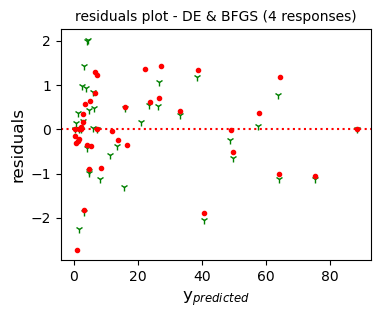

In [32]:
fig, ax = plt.subplots(figsize = (4,3))
ax.plot(y_pred_reduced_DE, residuals_reduced_DE, 'g1', mfc = 'none')
ax.plot(y_pred_reduced_BFGS, residuals_reduced_BFGS, 'r.')
ax.axhline(y=0, color = 'r', linestyle = ':')
ax.set_xlabel('y$_{predicted}$', fontsize = 12)
ax.set_ylabel('residuals', fontsize = 12)
ax.set_title('residuals plot - DE & BFGS (4 responses)', fontsize = 10)

## Observations

Firstly, it seems that the convergence of the loss function **det(z.T.dot(z))** with 4 response variables is great when using **scipy (L-BFGS-B)** suggesting that the reduced data set leads to more accurate predictions in this case.

Conversely, both the **scipy (DE)** with **lsq** loss function and **lmfit** seems to perform slightly better when 5 responses are used.

# Conclusions

*Both optimization algorithms (i.e., lmfit & scipy) are equally efficient and can be used accordingly.*